In [1]:
%matplotlib inline 
%load_ext autoreload 
%autoreload 2

__author__ = 'Song Huang'
__email__ = 'shuang89@ucsc.edu'
__version__ = '170505A'

from __future__ import (print_function, division, absolute_import)

import os
import glob
import copy
import sys
import warnings
import subprocess

import numpy as np
#import seaborn as sns
#sns.set(color_codes=True, style="darkgrid")

# Matplotlib related
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.style.use('classic')
plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

from astropy.io import fits
from astropy.table import \
    Table, \
    Column, \
    vstack, \
    unique
    
from astropy.utils.metadata import MergeConflictWarning
warnings.filterwarnings('ignore', category=MergeConflictWarning, 
                        append=True)
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.utils.console import ProgressBar

import hsc_massive
from hsc_massive import \
    s16a_path, \
    sample_selection, \
    prepare_sed, \
    catalog_summary, \
    smhm, \
    plotting

#envir = s16a_path.set_env(version='astro4')
envir = s16a_path.set_env(version='kungpao')

ORG = plotting.ORG
BLK = plotting.BLK
BLU = plotting.BLU
GRN = plotting.GRN

In [2]:
from kungpao.isophote.ellipse import Ellipse
from kungpao.isophote.ellipse import Centerer
from kungpao.isophote.ellipse import Geometry
from kungpao.isophote.ellipse.model import build_model

# Test data

In [3]:
gal_img = fits.open('redadd_529_HSC-I_full_img.fits')[0].data
gal_bad = fits.open('redadd_529_HSC-I_full_bad.fits')[0].data
gal_sig = fits.open('redadd_529_HSC-I_full_sig.fits')[0].data

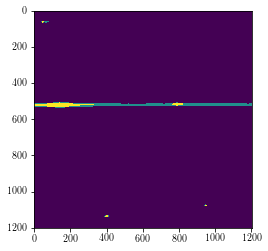

In [4]:
plt.imshow(gal_bad)

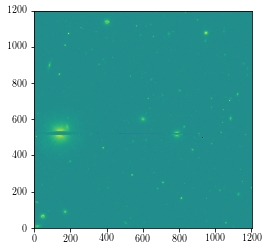

In [5]:
plt.imshow(np.arcsinh(gal_img), origin='lower')

In [6]:
gal_img[gal_bad > 0] = np.nan

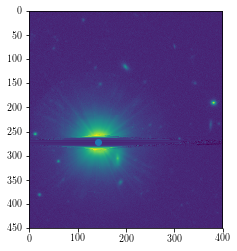

In [4]:
obj1 = gal_img[400:800, 400:800]
obj2 = gal_img[250:700, 0:400]

plt.imshow(np.arcsinh(obj2))
plt.scatter(142, 271)

In [5]:
obj1_geom = Geometry(600.1, 600.1, 4., 0.1, 10./180.*np.pi)
obj1_ellip = Ellipse(obj1, geometry=obj1_geom)

Centering on object....   
Done. Found x0 = 200.0, y0 = 200.0


In [6]:
obj2_geom = Geometry(142.0, 271.0, 10., 0.01, 0.0)
obj2_ellip = Ellipse(obj2, geometry=obj2_geom)

Centering on object....   
Done. Below threshold. Keeping original coordinates.


In [7]:
obj1_isolist = obj1_ellip.fit_image(sma0=5.0, minsma=0.0, maxsma=150.0, 
                                    step=0.15, linear=False, 
                                    sclip=3., nclip=3, 
                                    conver=0.05, maxit=50, fflag=0.7, 
                                    fixgeom=False)

#
# Semi-      Isophote         Ellipticity    Position     Grad.   Data  Flag Iter. Stop
# major        mean                           Angle        rel.                    code
# axis       intensity                                    error
#(pixel)                                     (degree)
#
   5.00       10.80 ( 0.01)  0.109 (0.001) 147.59 ( 0.2)  0.012    30     0   20     0
   5.75        8.68 ( 0.01)  0.118 (0.000) 149.44 ( 0.1)  0.010    34     0   10     0
   6.61        6.83 ( 0.01)  0.122 (0.000) 150.06 ( 0.1)  0.011    39     0   10     0
   7.60        5.32 ( 0.01)  0.128 (0.000) 150.41 ( 0.1)  0.011    45     0   10     0
   8.75        4.07 ( 0.01)  0.130 (0.000) 151.30 ( 0.1)  0.013    51     1   10     0
  10.06        3.10 ( 0.01)  0.136 (0.001) 152.00 ( 0.1)  0.017    59     0   10     0
  11.57        2.31 ( 0.01)  0.133 (0.001) 154.54 ( 0.1)  0.019    68     0   10     0
  13.30        1.72 ( 0.00)  0.131 (0.001) 152.13 ( 0.1)  0.022    78     0   10     0
  15.3

In [8]:
obj2_isolist = obj2_ellip.fit_image(sma0=40.0, minsma=18.0, maxsma=120.0, 
                                    step=0.15, linear=False, integrmode='median', 
                                    sclip=2.0, nclip=2, 
                                    conver=0.07, maxit=80, fflag=0.8, fixgeom=False)

#
# Semi-      Isophote         Ellipticity    Position     Grad.   Data  Flag Iter. Stop
# major        mean                           Angle        rel.                    code
# axis       intensity                                    error
#(pixel)                                     (degree)
#
  40.00        6.29 ( 0.09)  0.022 (0.003)  36.14 ( 4.8)  0.077    66    12   20     0
  46.00        4.26 ( 0.08)  0.022 (0.003)  36.14 ( 4.6)  0.095    73    17    2     1
  52.90        2.98 ( 0.06)  0.057 (0.003)  41.97 ( 1.7)  0.088    84    16   10     0
  60.83        1.85 ( 0.02)  0.034 (0.002)  41.97 ( 1.8)  0.061    98    20   10     0
  69.96        1.14 ( 0.01)  0.026 (0.002)  47.54 ( 2.0)  0.055   110    17   10     0
  80.45        0.75 ( 0.01)  0.031 (0.002)  17.01 ( 1.5)  0.057   112    15   10     0
  92.52        0.51 ( 0.01)  0.031 (0.002)  17.01 ( 1.7)  0.066   115    12    1     5
 106.40        0.35 ( 0.01)  0.031 (0.001)  17.01 ( 0.5)  None    114    13    1     5
  34.7

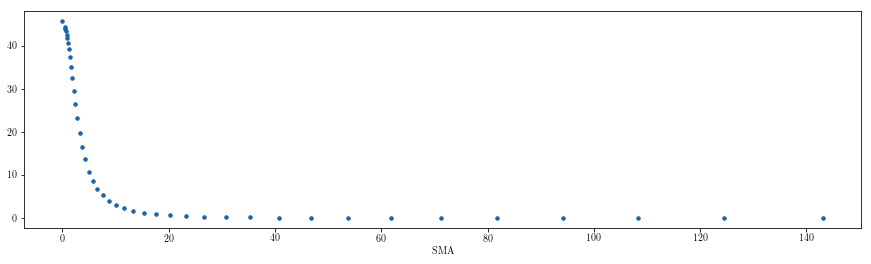

In [9]:
plt.figure(figsize=(15,4))
plt.scatter(obj1_isolist.sma, obj1_isolist.intens, s=12, c=BLU(0.8))
plt.xlabel(r'$\mathrm{SMA}$')

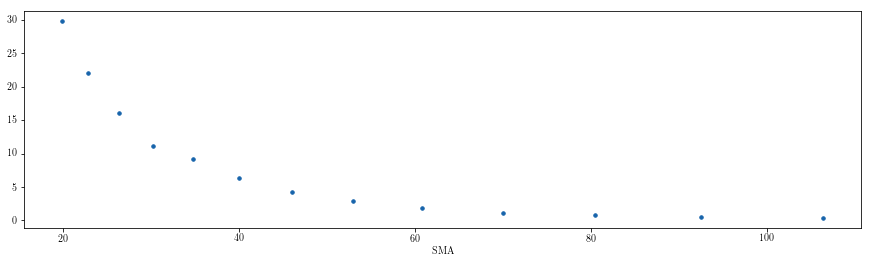

In [10]:
plt.figure(figsize=(15,4))
plt.scatter(obj2_isolist.sma, obj2_isolist.intens, s=12, c=BLU(0.8))
plt.xlabel(r'$\mathrm{SMA}$')

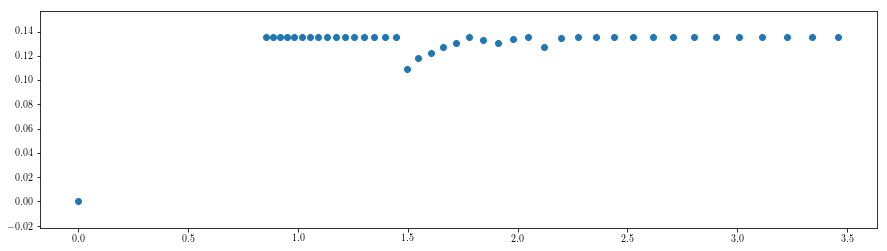

In [11]:
plt.figure(figsize=(15,4))
plt.scatter(obj1_isolist.sma ** 0.25, obj1_isolist.eps)

Interpolating....
Done
SMA=143.1
Done


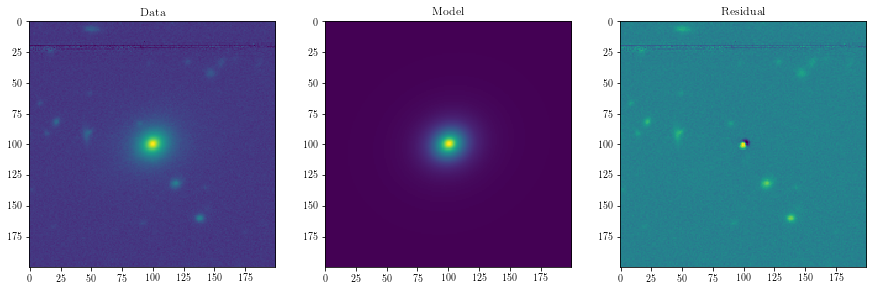

In [12]:
obj1_model = build_model(obj1, obj1_isolist, high_harmonics=False)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))

ax1.imshow(np.arcsinh(obj1)[100:300, 100:300])
ax1.set_title(r"$\mathrm{Data}$")

ax2.imshow(np.arcsinh(obj1_model)[100:300, 100:300])
ax2.set_title(r"$\mathrm{Model}$")

ax3.imshow(np.arcsinh(obj1 - obj1_model)[100:300, 100:300])
ax3.set_title(r"$\mathrm{Residual}$")

Interpolating....
Done
SMA=114.1
Done


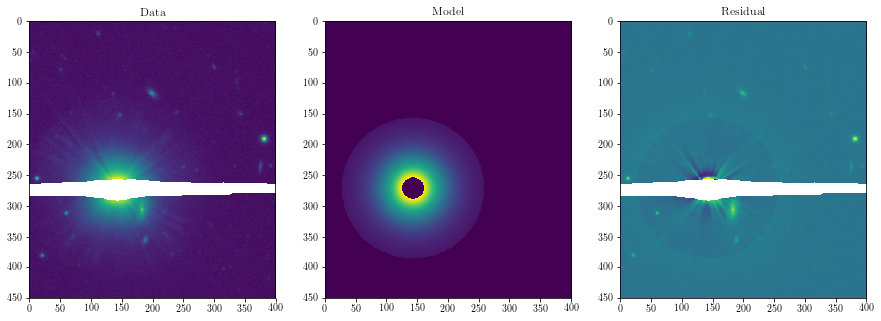

In [15]:
obj2_model = build_model(obj2, obj2_isolist, high_harmonics=False, step=0.3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))

ax1.imshow(np.arcsinh(obj2))
ax1.set_title(r"$\mathrm{Data}$")

ax2.imshow(np.arcsinh(obj2_model))
ax2.set_title(r"$\mathrm{Model}$")

ax3.imshow(np.arcsinh(obj2 - obj2_model))
ax3.set_title(r"$\mathrm{Residual}$")

# Test model interpolation

In [132]:
from scipy.interpolate import UnivariateSpline 
from scipy.interpolate import LSQUnivariateSpline

nodes = isolist.sma[2:-2]

finely_spaced_sma = np.arange(isolist[0].sma, isolist[-1].sma, 0.10)

intens = LSQUnivariateSpline(isolist.sma, isolist.intens, nodes)(finely_spaced_sma)
eps    = LSQUnivariateSpline(isolist.sma, isolist.eps,    nodes)(finely_spaced_sma)
pa     = LSQUnivariateSpline(isolist.sma, isolist.pa,     nodes)(finely_spaced_sma)
x0     = LSQUnivariateSpline(isolist.sma, isolist.x0,     nodes)(finely_spaced_sma)
y0     = LSQUnivariateSpline(isolist.sma, isolist.y0,     nodes)(finely_spaced_sma)

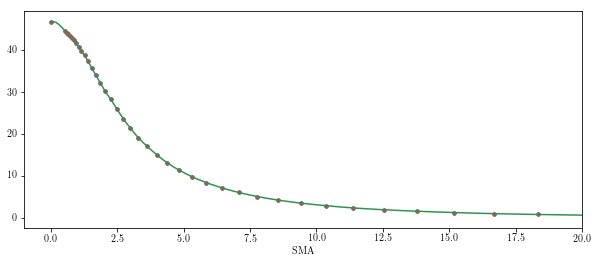

In [133]:
plt.figure(figsize=(10,4))
plt.scatter(isolist2.sma, isolist2.intens, s=12, c=BLU(0.8))
plt.scatter(isolist.sma, isolist.intens, s=8, c=ORG(0.7))
plt.plot(finely_spaced_sma, intens, c=GRN(0.7))
plt.xlim(-1.0, 20.0)
plt.xlabel(r'$\mathrm{SMA}$')

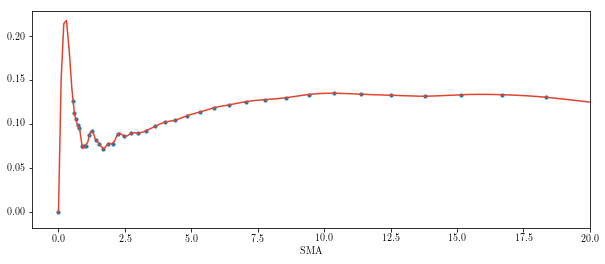

In [134]:
plt.figure(figsize=(10,4))
plt.scatter(isolist.sma, isolist.eps, s=10)
plt.plot(finely_spaced_sma, eps, c=ORG(0.7))
plt.xlim(-1.0, 20.0)
plt.xlabel(r'$\mathrm{SMA}$')